# Automatic detection of the occupation of an interior space

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

**Preparing data**

In [2]:
df = pd.read_csv("datasetEn.csv")
df_un = pd.read_csv("dataset_unclassified.csv")

**Explanatory Data Analysis**

In [3]:
df.describe

<bound method NDFrame.describe of        id_record  temperature  relative_humidity        light          CO2  \
0          20019    20.513802          29.911067  1012.993709   783.551679   
1          29077    21.347758          18.760759   165.049937   477.166606   
2          17474    20.712988          33.721442     0.000000   517.784597   
3          26163    20.138632          34.154604   149.785610  1515.136696   
4          16665    22.761815          30.479519   608.948933  1012.253115   
...          ...          ...                ...          ...          ...   
11995      30246    21.723261          27.503064   399.628688  1071.844655   
11996      24866    19.865724          19.443050     0.000000   458.272078   
11997      26543    21.416242          25.287051   279.024395   445.316161   
11998      23871    19.653193          25.579196     0.000000   913.788844   
11999      28422    21.288691          32.160466     0.000000   454.710728   

       absolute_humidity  occ

In [4]:
n = df.groupby("occupation", as_index=False).count()["absolute_humidity"][0]
a = df.groupby("occupation", as_index=False).count()["absolute_humidity"][1]
print("Normal: ", n/(a+n), "%")
print("Anomaly: ", a/(a+n), "%")

Normal:  0.7666666666666667 %
Anomaly:  0.23333333333333334 %


In [5]:
#What to do with null values?
df.isna().sum()

id_record            0
temperature          2
relative_humidity    0
light                4
CO2                  0
absolute_humidity    0
occupation           0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.head()

,id_record,temperature,relative_humidity,light,CO2,absolute_humidity,occupation
0,20019,20.513802,29.911067,1012.993709,783.551679,0.004371,0
1,29077,21.347758,18.760759,165.049937,477.166606,0.002899,0
2,17474,20.712988,33.721442,0.000000,517.784597,0.004799,0
3,26163,20.138632,34.154604,149.785610,1515.136696,0.004924,0
4,16665,22.761815,30.479519,608.948933,1012.253115,0.004944,1


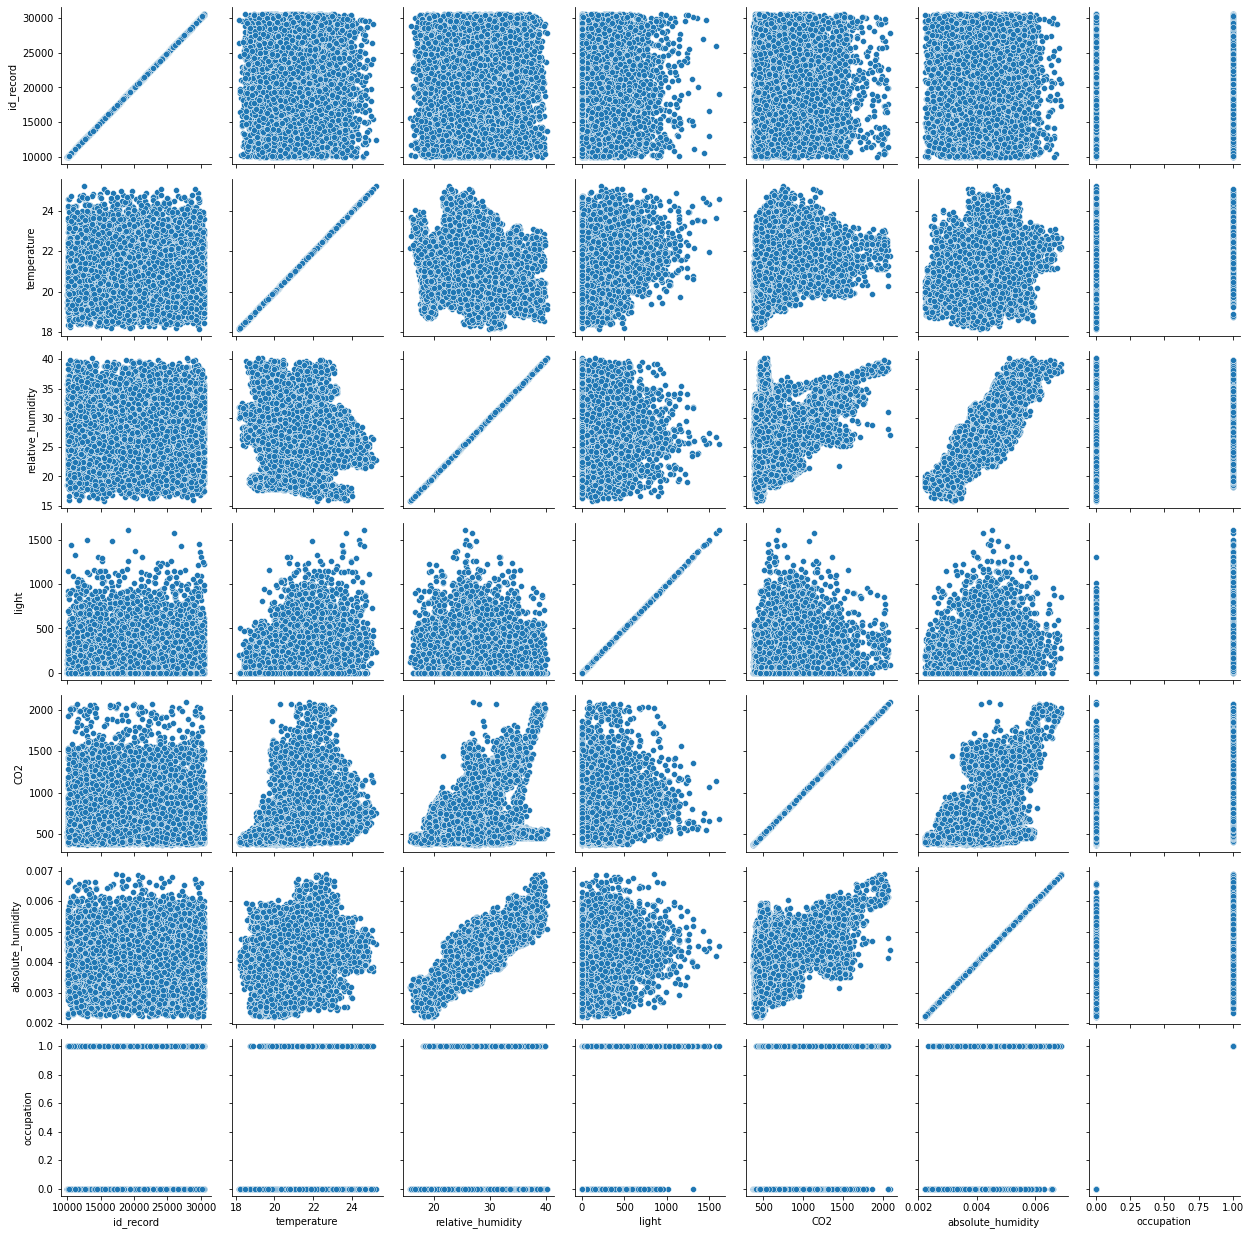

In [8]:
sns.PairGrid(df).map(sns.scatterplot)

<AxesSubplot:>

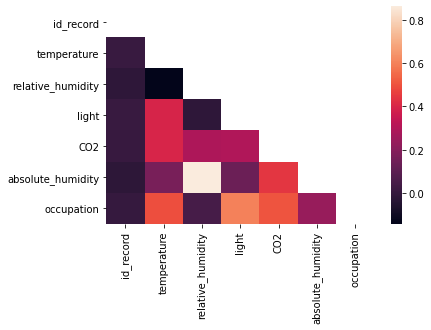

In [9]:
correlation = df.corr()
mask = np.triu(np.ones_like(correlation))
sns.heatmap(data=correlation, mask=mask)

In [10]:
correlation

,id_record,temperature,relative_humidity,light,CO2,absolute_humidity,occupation
id_record,1.000000,0.008970,-0.019747,0.008697,0.002456,-0.022512,0.001410
temperature,0.008970,1.000000,-0.143091,0.395475,0.396868,0.166617,0.491876
relative_humidity,-0.019747,-0.143091,1.000000,-0.017819,0.288052,0.863434,0.045060
light,0.008697,0.395475,-0.017819,1.000000,0.295361,0.132152,0.596706
CO2,0.002456,0.396868,0.288052,0.295361,1.000000,0.440883,0.504938
absolute_humidity,-0.022512,0.166617,0.863434,0.132152,0.440883,1.000000,0.237455
occupation,0.001410,0.491876,0.045060,0.596706,0.504938,0.237455,1.000000


It can be observed that the highest correlation is between:
- relative and absolute humidity
- **occupation and light**
- **occupation and CO2**
- **occupation and temperature**

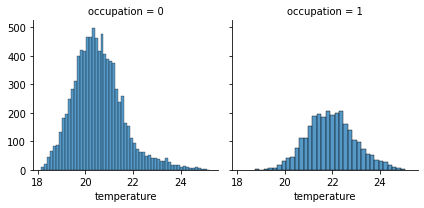

In [11]:
g = sns.FacetGrid(df, col="occupation", margin_titles=True)
g.map(sns.histplot, "temperature")

<AxesSubplot:xlabel='temperature', ylabel='Count'>

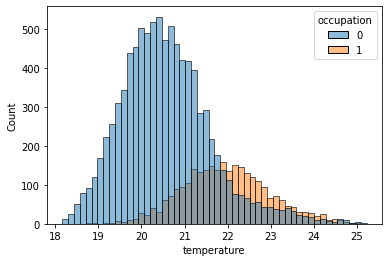

In [12]:
sns.histplot(data=df, x="temperature", hue="occupation")

<AxesSubplot:xlabel='occupation', ylabel='temperature'>

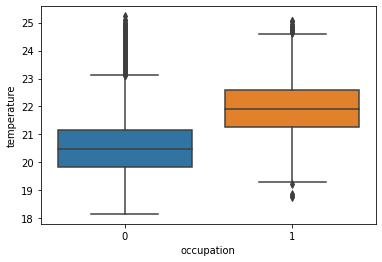

In [13]:
sns.boxplot(data=df, x="occupation", y="temperature")

We can see that the biggest gap between normality and anomaly is in interval between 22 and 23.5 degrees of celcius. Above 23.5 degrees of celcius the gap is smaller but still anomalies occurrence is slightly higher.

<AxesSubplot:xlabel='CO2', ylabel='Count'>

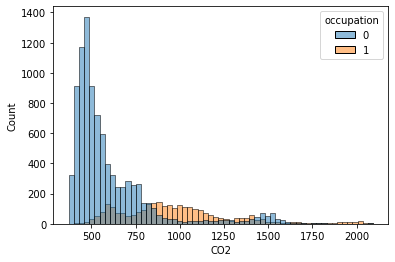

In [14]:
sns.histplot(data=df, x="CO2", hue="occupation")

<AxesSubplot:xlabel='occupation', ylabel='temperature'>

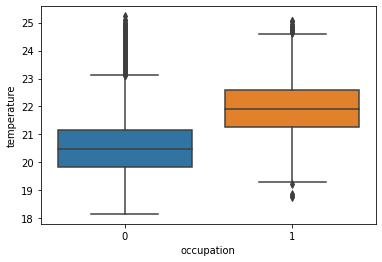

In [15]:
sns.boxplot(data=df, x="occupation", y="temperature")

It is worth to notice that in the case of occupation = 1 there is almost none low CO2 intensity and a lot of higher intensities.

<AxesSubplot:xlabel='light', ylabel='Count'>

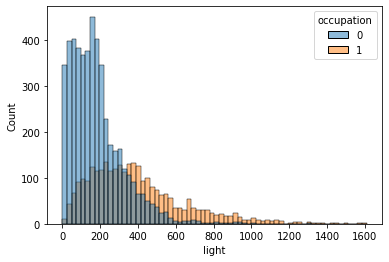

In [16]:
sns.histplot(data=df.loc[df.light > 0], x="light", hue="occupation")

<AxesSubplot:xlabel='occupation', ylabel='light'>

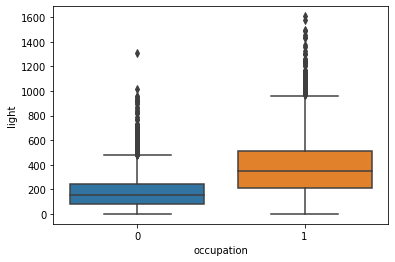

In [17]:
sns.boxplot(data=df.loc[df.light > 0], x="occupation", y="light")

Again, the distributions of light variable are different depending on an occupation.

Let's see how distributions of other variables - which weren't so well correlated with occupation as above variables - look like.

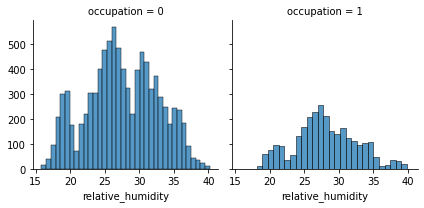

In [18]:
g = sns.FacetGrid(df, col="occupation", margin_titles=True)
g.map(sns.histplot, "relative_humidity" )

<AxesSubplot:xlabel='relative_humidity', ylabel='Count'>

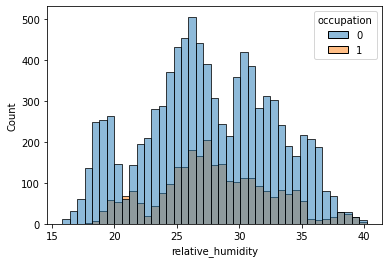

In [19]:
sns.histplot(data=df, x="relative_humidity", hue="occupation")

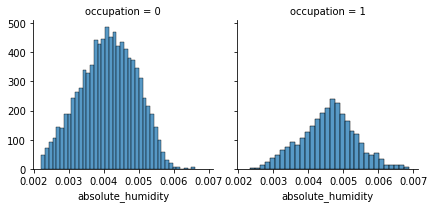

In [20]:
g = sns.FacetGrid(df, col="occupation", margin_titles=True)
g.map(sns.histplot, "absolute_humidity" )

<AxesSubplot:xlabel='absolute_humidity', ylabel='Count'>

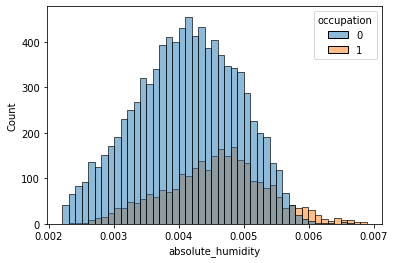

In [21]:
sns.histplot(data=df, x="absolute_humidity", hue="occupation")

# Building a model

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

Keeping in memory the fact that data is not homogenous, it means number of records with occupation = 1 is not equal to number of rows with occupation = 0, splitting the data for a train and a test set is not so obvious.

Let's use oversampling - adding copies of instances from the under-represented class with SMOTE.

Oversampling.

In [23]:
from collections import Counter
from imblearn.over_sampling import SMOTE

x = df.drop("occupation", axis=1)
y = df.occupation

counter = Counter(y)
print(counter) #imbalanced

Counter({0: 9199, 1: 2796})


In [24]:
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

counter = Counter(y)
print(counter) #balanced

Counter({0: 9199, 1: 9199})


After balancing dataset let's use train_test_split.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [26]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, x, y, cv=5, scoring="f1")

In [28]:
scores.mean() #in average, our model is accurate in 94%

0.9444130985531156

Now, let's tune the model.

In [29]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100,200,500],
    'max_depth': [10,25,50],
    'min_samples_leaf': [2,4,5],
    'min_samples_split': [2, 5, 10]   
}

cv = GridSearchCV(rf, params, scoring="f1", cv=3, verbose=3)

In [30]:
cv.fit(x_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.933 total time=   1.0s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.933 total time=   1.0s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.933 total time=   1.0s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.931 total time=   2.0s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.938 total time=   2.1s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.932 total time=   2.1s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.931 total time=   5.3s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.935 total time=  

[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=0.929 total time=   5.2s
[CV 2/3] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=0.933 total time=   5.1s
[CV 3/3] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=0.930 total time=   5.2s
[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.927 total time=   1.0s
[CV 2/3] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.932 total time=   0.9s
[CV 3/3] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.932 total time=   0.9s
[CV 1/3] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.928 total time=   2.0s
[CV 2/3] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=0.932 total time=   2.0s
[CV 3/3] END max_depth=10, min_samples_leaf=5, min_

[CV 2/3] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.933 total time=   2.5s
[CV 3/3] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=0.934 total time=   2.3s
[CV 1/3] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=0.932 total time=   6.0s
[CV 2/3] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=0.932 total time=   6.0s
[CV 3/3] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=0.934 total time=   5.8s
[CV 1/3] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.932 total time=   1.1s
[CV 2/3] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.933 total time=   1.1s
[CV 3/3] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.934 total time=   1.1s
[CV 1/3] END max_depth=25, min_samples_leaf=5, min_sampl

[CV 3/3] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.934 total time=   1.2s
[CV 1/3] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.934 total time=   2.4s
[CV 2/3] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.936 total time=   2.6s
[CV 3/3] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.932 total time=   2.4s
[CV 1/3] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.934 total time=   6.2s
[CV 2/3] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.934 total time=   6.4s
[CV 3/3] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.934 total time=   6.6s
[CV 1/3] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.931 total time=   1.3s
[CV 2/3] END max_depth=50, min_samples_leaf=5, mi

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 25, 50],
                         'min_samples_leaf': [2, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1', verbose=3)

In [31]:
cv.best_params_

{'max_depth': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [32]:
rf_2 = RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
rf_2.fit(x_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [33]:
scores = cross_val_score(rf_2, x, y, cv=5, scoring="f1_macro")

In [34]:
scores.mean() #in this case tuning doesn't help

0.9415022145291493

Let's use our x_test and y_test to train the final model.

In [35]:
rf = RandomForestClassifier()
rf.fit(x, y)

RandomForestClassifier()

Let's use rf model to predict unclassified data.

In [36]:
test_data = pd.read_csv("dataset_unclassified.csv")

In [43]:
test_data

,id_record,temperature,relative_humidity,light,CO2,absolute_humidity
0,17761,22.561779,29.744439,904.055524,806.036356,0.004797
1,25264,22.869926,33.894069,107.935028,1549.241728,0.006084
2,30252,20.486633,35.911496,57.554649,488.975145,0.005515
3,19288,20.305429,30.604171,0.000000,532.881435,0.004174
4,15273,21.012591,31.802713,0.000000,552.741722,0.004752
...,...,...,...,...,...,...
4995,23496,20.766583,33.914831,12.513803,680.039428,0.004756
4996,28084,20.988485,26.992550,0.000000,553.375764,0.004267
4997,21617,22.921429,38.810614,668.464032,1819.283814,0.006187
4998,24315,21.574549,37.346533,280.350097,1666.799807,0.005877


In [38]:
y_pred = rf.predict(test_data)

In [39]:
y_pred

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [66]:
result = test_data[["id_record"]]
result.insert(1,"occupation", y_pred)

In [67]:
result

,id_record,occupation
0,17761,1
1,25264,1
2,30252,0
3,19288,0
4,15273,0
...,...,...
4995,23496,0
4996,28084,0
4997,21617,1
4998,24315,1


In [86]:
result = result.astype('str')

In [87]:
result.dtypes

id_record     object
occupation    object
dtype: object

In [89]:
result.to_excel("classification_estimated2.xlsx", index=False)


In [90]:
pip install -U notebook-as-pdf

  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61087 sha256=60c80e2d267be71387ea5cc9c2ff4b6ba76c4908cc68fe1b5577c5604d4186c4
  Stored in directory: c:\users\kicpe\appdata\local\pip\cache\wheels\b1\1a\8f\a4c34be976825a2f7948d0fa40907598d69834f8ab5889de11
Successfully built PyPDF2
Note: you may need to restart the kernel to use updated packages.


In [93]:
pip install pyppeteer

Note: you may need to restart the kernel to use updated packages.
